In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

In [3]:
import os

In [5]:
df = pd.read_excel('df_final.xlsx')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Columns: 746 entries, Unnamed: 0 to conversion_current
dtypes: datetime64[ns](3), float64(728), int64(12), object(3)
memory usage: 3.5+ MB


In [ ]:
df.describe()

c:\Users\Пользователь\VSCode\Calls_Conversion_Prediction\myenv\lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Unnamed: 0,eom,num_expon_apps,num_apps,num_expon_apps_0,num_expon_apps_1,num_expon_apps_2,num_expon_apps_3plus,num_apps_0,num_apps_1,...,primary_calls,secondary_calls,target_calls_qty_T1,target_deals_qty_T1,plan_area,meetings_qty,agent_meetings_qty,deals,target_conversion_rate,conversion_current
count,620.000000,620,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,...,614.000000,614.000000,617.000000,453.000000,615.00000,610.000000,610.000000,362.000000,453.000000,613.000000
mean,316.500000,2023-02-19 02:44:54.193548288,654.816129,1388.237097,0.129032,201.487097,232.332258,113.398387,1.693548,516.812903,...,289.203583,259.633550,454.672609,38.357616,4103.30839,425.921311,29.298361,16.640884,0.096426,inf
min,7.000000,2022-03-31 00:00:00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,26.50000,2.000000,0.000000,1.000000,0.000561,0.000000
25%,161.750000,2022-09-30 00:00:00,138.250000,442.500000,0.000000,36.750000,42.000000,20.000000,0.000000,134.750000,...,88.250000,61.000000,143.000000,7.000000,1555.76500,138.250000,8.000000,3.000000,0.022613,0.000000
50%,316.500000,2023-02-28 00:00:00,382.000000,1211.500000,0.000000,141.000000,118.500000,60.000000,0.000000,422.500000,...,202.000000,171.500000,325.000000,19.000000,3704.34000,321.000000,19.000000,8.000000,0.071429,0.008621
75%,471.250000,2023-07-31 00:00:00,992.000000,2085.000000,0.000000,287.250000,358.750000,152.500000,0.000000,666.250000,...,399.000000,349.250000,640.000000,41.000000,5715.55500,625.250000,43.000000,19.000000,0.144019,0.056701
max,626.000000,2023-10-31 00:00:00,4429.000000,5613.000000,8.000000,2613.000000,1981.000000,1299.000000,29.000000,5107.000000,...,1616.000000,1633.000000,2398.000000,392.000000,17707.27000,1682.000000,198.000000,194.000000,1.000000,inf
std,179.122863,NaN,687.928023,1117.488570,1.008588,228.681007,269.405873,141.085983,5.705731,549.074172,...,270.035734,271.506295,413.326716,56.450818,3090.67527,356.236071,29.121615,24.125096,0.097051,NaN


In [ ]:
df.head()

,Unnamed: 0,smt_construction_projectid,eom,num_expon_apps,num_apps,num_expon_apps_0,num_expon_apps_1,num_expon_apps_2,num_expon_apps_3plus,num_apps_0,...,target_calls_qty_T1,target_deals_qty_T1,smt_name,smt_region_name,plan_area,meetings_qty,agent_meetings_qty,deals,target_conversion_rate,conversion_current
0,7,07091659-2705-E911-80E5-005056B8D207,2022-03-31,1690,1698,0,567,803,242,0,...,918.0,NaN,АЛХИМОВО,Москва,4346.03,604.0,47.0,NaN,NaN,0.000000
1,8,07091659-2705-E911-80E5-005056B8D207,2022-04-30,1326,1686,0,486,542,194,0,...,1029.0,NaN,АЛХИМОВО,Москва,4148.49,634.0,21.0,NaN,NaN,0.000000
2,9,07091659-2705-E911-80E5-005056B8D207,2022-05-31,1187,1628,0,345,538,152,0,...,1349.0,NaN,АЛХИМОВО,Москва,2963.20,933.0,34.0,NaN,NaN,0.000000
3,10,07091659-2705-E911-80E5-005056B8D207,2022-06-30,962,1504,0,347,397,131,0,...,1633.0,2.0,АЛХИМОВО,Москва,3556.00,1134.0,48.0,NaN,0.001225,0.000000
4,11,07091659-2705-E911-80E5-005056B8D207,2022-07-31,981,1405,0,340,399,104,0,...,1429.0,NaN,АЛХИМОВО,Москва,3840.37,1442.0,66.0,1.0,NaN,0.000881


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Columns: 746 entries, Unnamed: 0 to conversion_current
dtypes: datetime64[ns](3), float64(728), int64(12), object(3)
memory usage: 3.5+ MB


In [ ]:
# Сбросить опции к начальным значениям (по умолчанию)
pd.reset_option('display.max_columns')

In [ ]:
# Установить опцию для отображения всех столбцов
pd.set_option('display.max_columns', None)

# Теперь когда вы вызовете функцию isnull().sum(), все столбцы будут отображены
print(df.isnull().sum())

Unnamed: 0                      0
smt_construction_projectid      0
eom                             0
num_expon_apps                  0
num_apps                        0
                             ... 
meetings_qty                   10
agent_meetings_qty             10
deals                         258
target_conversion_rate        167
conversion_current              7
Length: 746, dtype: int64


In [ ]:
# Увеличить лимит вывода строк
pd.set_option('display.max_rows', None)

# Теперь когда вы вызовете функцию isnull().sum(), все строки будут отображены
print(df.isnull().sum())

Unnamed: 0                                                                            0
smt_construction_projectid                                                            0
eom                                                                                   0
num_expon_apps                                                                        0
num_apps                                                                              0
num_expon_apps_0                                                                      0
num_expon_apps_1                                                                      0
num_expon_apps_2                                                                      0
num_expon_apps_3plus                                                                  0
num_apps_0                                                                            0
num_apps_1                                                                            0
num_apps_2                      

In [ ]:
import pandas as pd
import numpy as np

# Проверка типов столбцов
df.dtypes

# Замена значений NaN на средние (mean) для числовых столбцов
for col in df.select_dtypes(include=[np.number]).columns:
    df[col].fillna(df[col].mean(), inplace=True)

# Замена значений Nan для нечисловых столбцов
# Если имеется необходимость заменить NaN в нечисловых столбцах, их следует обработать отдельно
# Например, заменить на самое часто встречающееся значение, пустую строку или другой подход
# Пример замены NaN на пустую строку в столбцах типа object:
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna('', inplace=True)

In [ ]:
df.head()

,Unnamed: 0,smt_construction_projectid,eom,num_expon_apps,num_apps,num_expon_apps_0,num_expon_apps_1,num_expon_apps_2,num_expon_apps_3plus,num_apps_0,num_apps_1,num_apps_2,num_apps_3plus,expon_area,total_expon_share,0rooms_expon_share,1rooms_expon_share,2rooms_expon_share,3plusrooms_expon_share,start_date,expon_start_date,days_from_last_start_of_sale,days_to_next_finish_date,mean_total_area_0,mean_total_area_1,mean_total_area_2,mean_total_area_3plus,mean_living_area_0,mean_living_area_1,mean_living_area_2,mean_living_area_3plus,mean_price,reservation_qty,agent_reservation_qty,sold_area,sold_sum,sold_price,project_id,house_id,expon__g_project__finish_id_eq_4__avg__1_1M,expon__g_project__finish_id_eq_4__avg__1_2M,expon__g_project__finish_id_eq_4__avg__1_3M,expon__g_project__finish_id_eq_7__avg__1_1M,expon__g_project__finish_id_eq_7__avg__1_2M,expon__g_project__finish_id_eq_7__avg__1_3M,expon__g_project__finish_id_eq_3__avg__1_1M,expon__g_project__finish_id_eq_3__avg__1_2M,expon__g_project__finish_id_eq_3__avg__1_3M,expon__g_project__finish_id_eq_15__avg__1_1M,expon__g_project__finish_id_eq_15__avg__1_2M,expon__g_project__finish_id_eq_15__avg__1_3M,expon__g_project__finish_id_eq_5__avg__1_1M,expon__g_project__finish_id_eq_5__avg__1_2M,expon__g_project__finish_id_eq_5__avg__1_3M,expon__g_house__finish_id_eq_4__avg__1_1M,expon__g_house__finish_id_eq_4__avg__1_2M,expon__g_house__finish_id_eq_4__avg__1_3M,expon__g_house__finish_id_eq_7__avg__1_1M,expon__g_house__finish_id_eq_7__avg__1_2M,expon__g_house__finish_id_eq_7__avg__1_3M,expon__g_house__finish_id_eq_3__avg__1_1M,expon__g_house__finish_id_eq_3__avg__1_2M,expon__g_house__finish_id_eq_3__avg__1_3M,expon__g_house__finish_id_eq_15__avg__1_1M,expon__g_house__finish_id_eq_15__avg__1_2M,expon__g_house__finish_id_eq_15__avg__1_3M,expon__g_house__finish_id_eq_5__avg__1_1M,expon__g_house__finish_id_eq_5__avg__1_2M,expon__g_house__finish_id_eq_5__avg__1_3M,expon__g_project__area__sum__1_1M,expon__g_project__area__sum__1_2M,expon__g_project__area__sum__1_3M,expon__g_house__area__sum__1_1M,expon__g_house__area__sum__1_2M,expon__g_house__area__sum__1_3M,expon__g_project__area__avg__1_1M,expon__g_project__area__avg__1_2M,expon__g_project__area__avg__1_3M,expon__g_project__area__min__1_1M,expon__g_project__area__min__1_2M,expon__g_project__area__min__1_3M,expon__g_project__area__max__1_1M,expon__g_project__area__max__1_2M,expon__g_project__area__max__1_3M,expon__g_project__cost__avg__1_1M,expon__g_project__cost__avg__1_2M,expon__g_project__cost__avg__1_3M,expon__g_project__cost__min__1_1M,expon__g_project__cost__min__1_2M,expon__g_project__cost__min__1_3M,expon__g_project__cost__max__1_1M,expon__g_project__cost__max__1_2M,expon__g_project__cost__max__1_3M,expon__g_project__price__avg__1_1M,expon__g_project__price__avg__1_2M,expon__g_project__price__avg__1_3M,expon__g_project__price__min__1_1M,expon__g_project__price__min__1_2M,expon__g_project__price__min__1_3M,expon__g_project__price__max__1_1M,expon__g_project__price__max__1_2M,expon__g_project__price__max__1_3M,expon__g_project__rooms__avg__1_1M,expon__g_project__rooms__avg__1_2M,expon__g_project__rooms__avg__1_3M,expon__g_project__rooms__min__1_1M,expon__g_project__rooms__min__1_2M,expon__g_project__rooms__min__1_3M,expon__g_project__rooms__max__1_1M,expon__g_project__rooms__max__1_2M,expon__g_project__rooms__max__1_3M,expon__g_project__floor__avg__1_1M,expon__g_project__floor__avg__1_2M,expon__g_project__floor__avg__1_3M,expon__g_project__floor__min__1_1M,expon__g_project__floor__min__1_2M,expon__g_project__floor__min__1_3M,expon__g_project__floor__max__1_1M,expon__g_project__floor__max__1_2M,expon__g_project__floor__max__1_3M,expon__g_house__area__avg__1_1M,expon__g_house__area__avg__1_2M,expon__g_house__area__avg__1_3M,expon__g_house__area__min__1_1M,expon__g_house__area__min__1_2M,expon__g_house__area__min__1_3M,expon__g_house__area__max__1_1M,expon__g_house__area__max__1_2M,expon__g_house__area__max__1_3M,expon__g_house__cost__avg__1

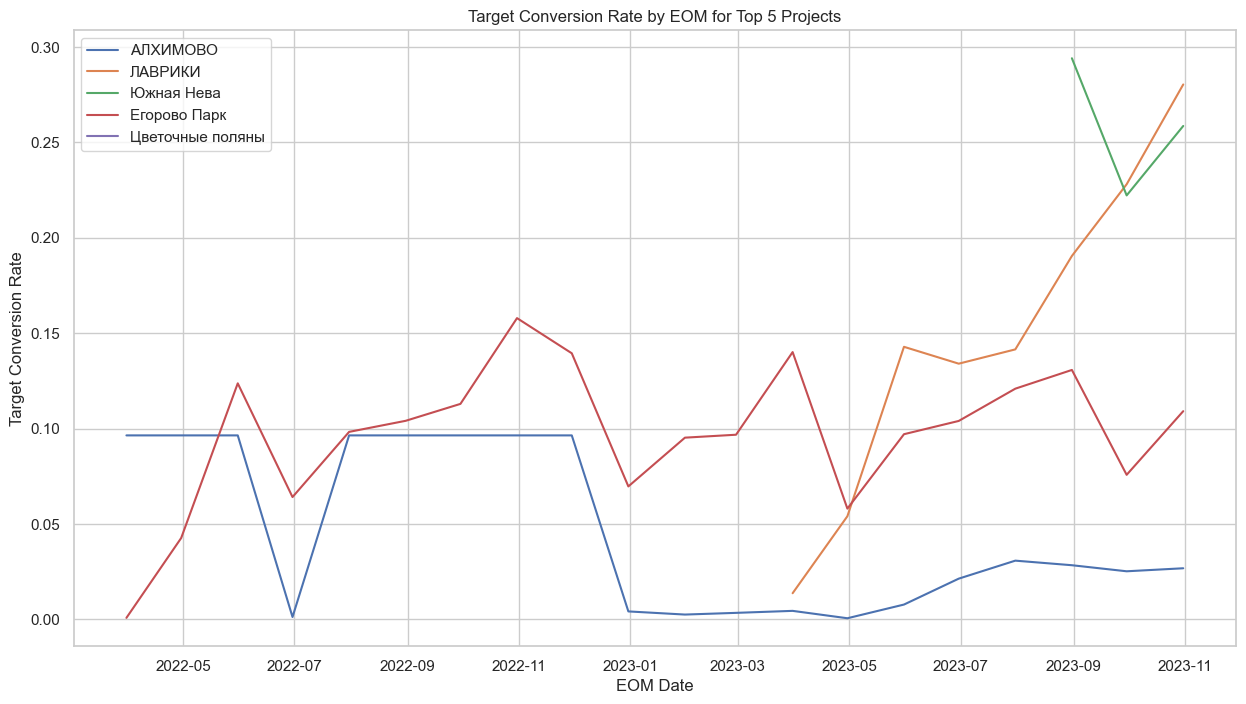

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Получаем список уникальных имен проектов
unique_projects = df['smt_name'].unique()

# Отбираем первые 5 проектов
top_projects = unique_projects[:5]

# Фильтруем DataFrame для отображения данных только для первых 5 проектов
top_projects_df = df[df['smt_name'].isin(top_projects)]

# Установка стиля для графиков (необязательно)
sns.set(style="whitegrid")

# Создание графика
plt.figure(figsize=(15, 8))

# Цикл по каждому из пяти проектов для отдельного отображения на графике
for project in top_projects:
    # Фильтрация DataFrame для каждого проекта
    project_df = top_projects_df[top_projects_df['smt_name'] == project]
    
    # Сортировка данных по дате 'eom' для линейной визуализации по времени
    project_df = project_df.sort_values('eom')
    
    # Визуализация линейного графика для текущего проекта
    plt.plot(project_df['eom'], project_df['target_conversion_rate'], label=project)
    
# Подписи к графику
plt.xlabel('EOM Date')
plt.ylabel('Target Conversion Rate')
plt.title('Target Conversion Rate by EOM for Top 5 Projects')

# Добавление легенды
plt.legend()

# Отображение графика
plt.show()

In [ ]:
# Применение One-Hot Encoding к столбцам 'smt_name' и 'smt_region_name'
df = pd.get_dummies(df, columns=['smt_name', 'smt_region_name'])

KeyError: "None of [Index(['smt_name', 'smt_region_name'], dtype='object')] are in the [columns]"

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_16212\2751150132.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_correlations.values, y=sorted_correlations.index, palette='viridis')


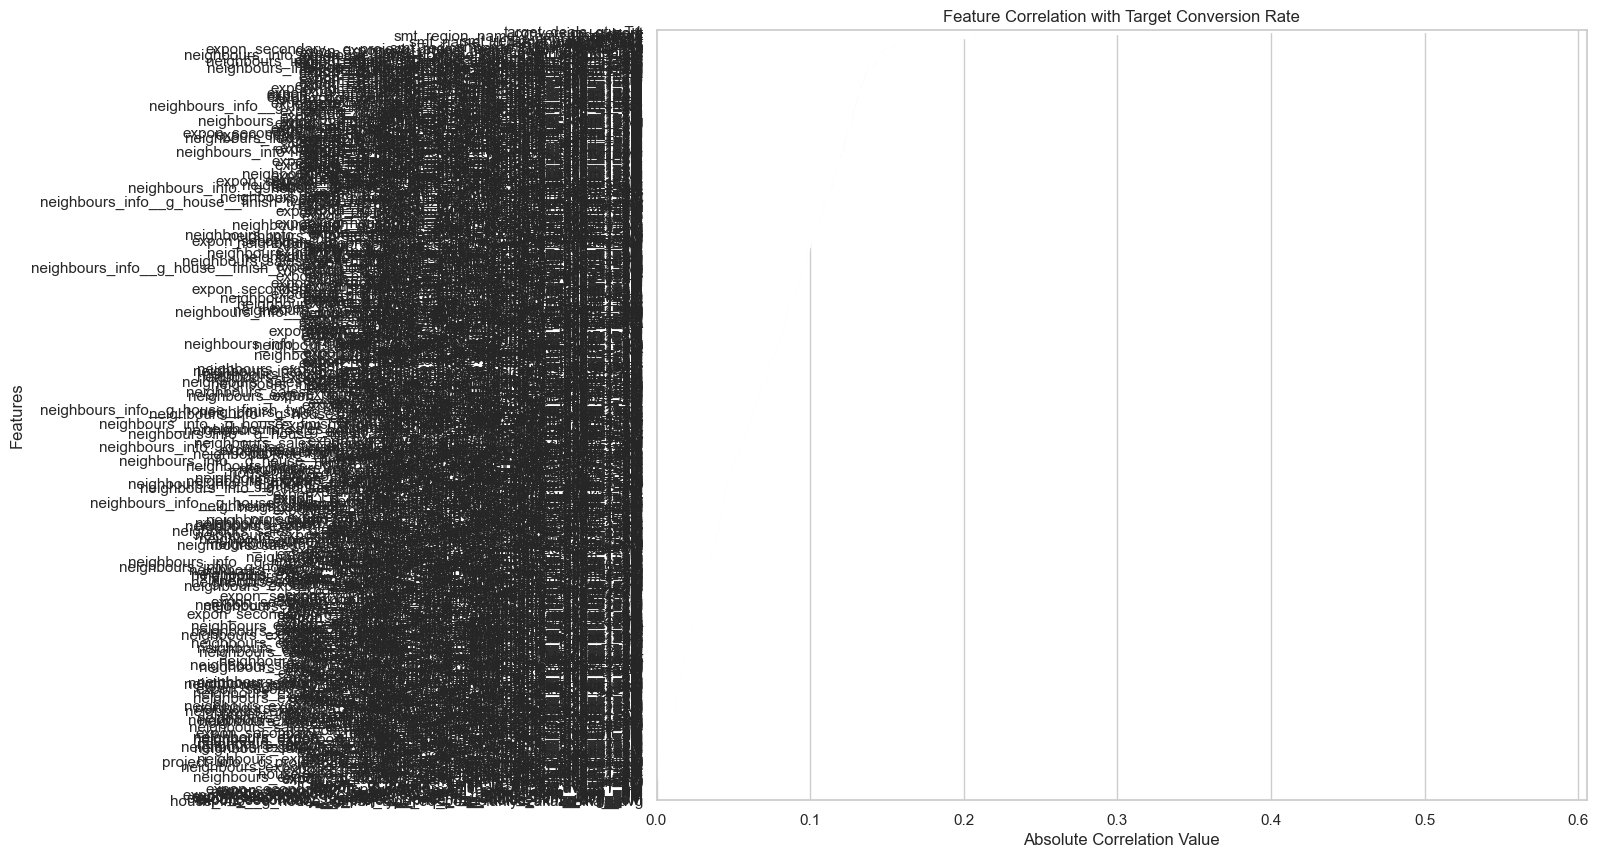

In [ ]:
# Предварительно убедитесь, что 'target_conversion_rate' в вашем DataFrame не содержит NaN
df['target_conversion_rate'].fillna(df['target_conversion_rate'].mean(), inplace=True)

# Вычисление корреляционной матрицы для DataFrame
correlation_matrix = df.corr()

# Извлечение корреляций со столбцом 'target_conversion_rate'
target_correlations = correlation_matrix['target_conversion_rate'].drop('target_conversion_rate')  # Исключаем корреляцию с самим собой

# Сортировка значений корреляций по убыванию
sorted_correlations = target_correlations.abs().sort_values(ascending=False)

# Визуализация отсортированных корреляций в виде столбчатой диаграммы
plt.figure(figsize=(12, 10))
sns.barplot(x=sorted_correlations.values, y=sorted_correlations.index, palette='viridis')

# Добавление названий осей и заголовка графика
plt.xlabel('Absolute Correlation Value')
plt.ylabel('Features')
plt.title('Feature Correlation with Target Conversion Rate')

# Отображение диаграммы
plt.show()

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_16212\4162876902.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=subset_correlations.values, y=subset_correlations.index, palette='viridis')


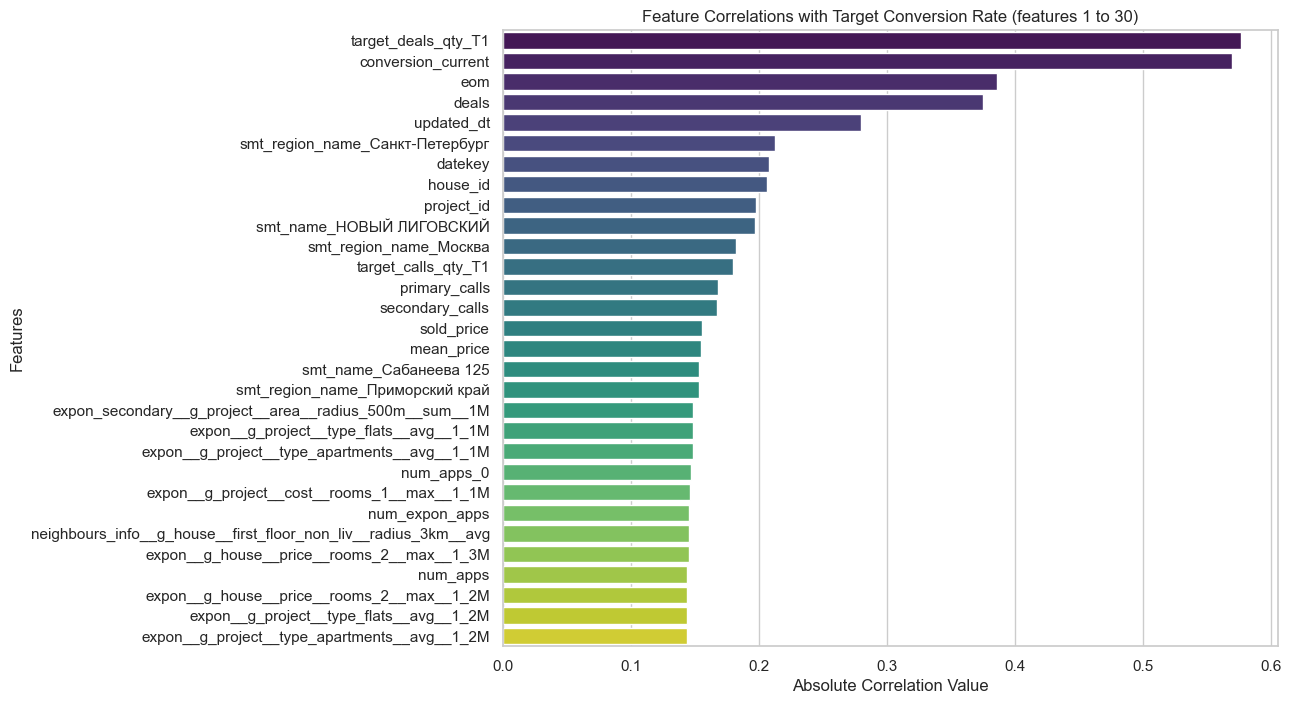

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_16212\4162876902.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=subset_correlations.values, y=subset_correlations.index, palette='viridis')


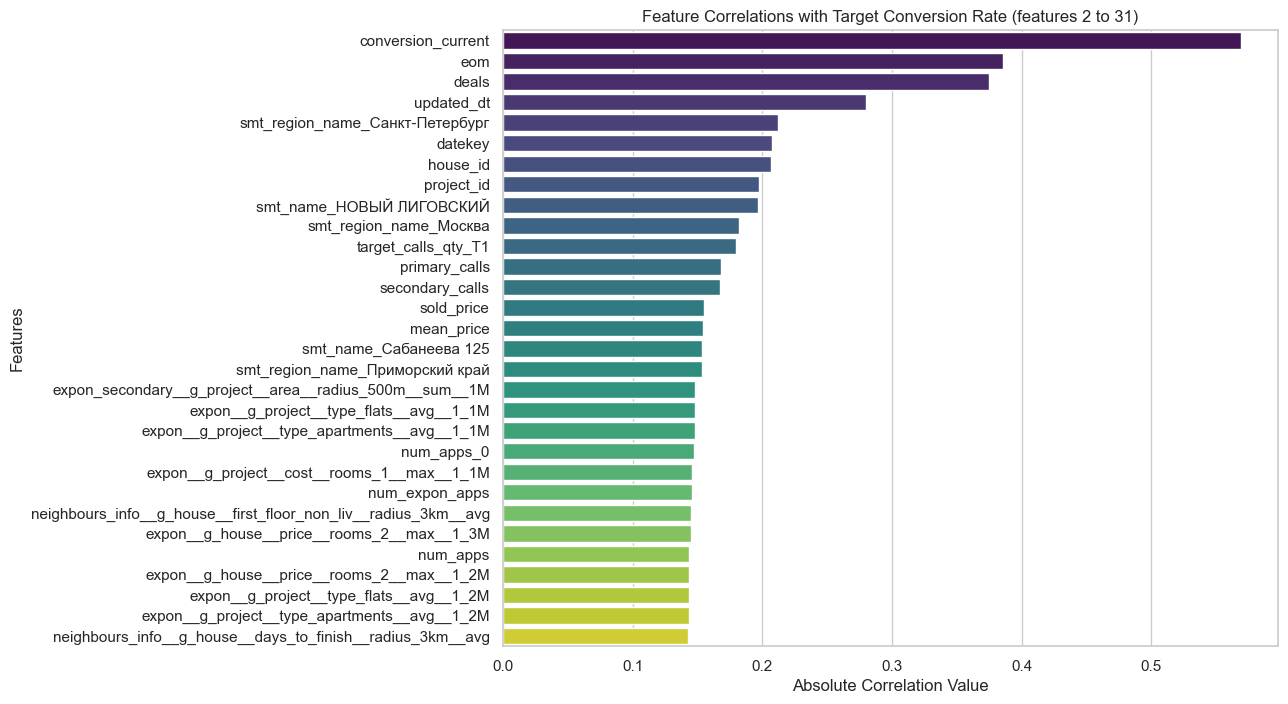

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Количество фичей на каждом графике
features_per_plot = 30

# Сортировка значений корреляций по убыванию, исключая сам target
sorted_correlations = target_correlations.abs().sort_values(ascending=False)

# Итерация по корреляциям с шагом в 30 фичей
#for i in range(0, len(sorted_correlations), features_per_plot):
for i in range(2):  
    # Слайс для текущего набора из 30 фичей
    subset_correlations = sorted_correlations[i:i+features_per_plot]
    
    # Создание и размер графика
    plt.figure(figsize=(10, 8))
    
    # Строим график для текущего подмножества фичей
    sns.barplot(x=subset_correlations.values, y=subset_correlations.index, palette='viridis')
    
    # Настройка меток и заголовков
    plt.xlabel('Absolute Correlation Value')
    plt.ylabel('Features')
    plt.title(f'Feature Correlations with Target Conversion Rate (features {i+1} to {i+len(subset_correlations)})')
    
    # Отображение графика
    plt.show()

## Модель #1

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#df.drop('smt_construction_projectid', axis=1, inplace=True)

# Допустим, x - ваши факторы, y - target_conversion_rate
X = df.drop('target_conversion_rate', axis=1)
y = df['target_conversion_rate']

# Разделите данные на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Обучение модели
model = LinearRegression()
model.fit(X_train, y_train)

# Прогнозирование на тестовом наборе
y_pred = model.predict(X_test)

# Оценка модели
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}, R2: {r2}')

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>)

In [ ]:
import tensorflow as tf

In [ ]:
import keras

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization, Dropout, Conv1D, MaxPooling1D

# Предполагается, что данные были предварительно обработаны и нормализованы

# Входной размер данных: (batch_size, time_steps, num_features)
input_shape = (None, X_train.shape[1], X_train.shape[2]) # уточните shape ваших входных данных

model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
# Если есть последовательные временные зависимости
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=32))
# Полносвязный слой для интеграции линейных фич
model.add(Dense(64, activation='relu'))
# Dropout для регуляризации
model.add(Dropout(0.5))
# Выходной слой для предсказания одного значения
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Обучение модели
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

IndexError: tuple index out of range